# Urban Sound Classification Project

# 1. Dataset Introduction

The UrbanSound8K dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: 
(1) air_conditioner; (2) car_horn; (3) children_playing; (4) dog_bark; (5) drilling; (6) engine_idling; (7) gun_shot; (8) jackhammer; (9) siren; (10) street_music.

The home page of this dataset is: https://urbansounddataset.weebly.com/urbansound8k.html

After decompress, there two folders under the root directory:
* metadata: The information of audio files.
* audio: The raw audio files.

The following code shows the part of the metadata of the dataset:

In [1]:
import pandas as pd
index = pd.read_csv('../raw/metadata/UrbanSound8K.csv')
index.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

The meanings of every columns in table above can be founded in the home page of UrbanSound8K dataset.

Besides, the audio files was preprocessed and arranged in 10 folds. The following code shows the directory structure:

In [2]:
import os
AUDIO_SOURCE = '../raw/audio'
folders = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5',
           'fold6', 'fold7', 'fold8', 'fold9', 'fold10']
count = 0
for folder in folders:
    path = os.path.join(AUDIO_SOURCE, folder)
    for root, dirs, files in os.walk(path):
        count += len(files)
        print('There are %d audio in %s.' % (len(files), folder))

print('%d audio in total.' % count)

There are 873 audio in fold1.
There are 888 audio in fold2.
There are 925 audio in fold3.
There are 990 audio in fold4.
There are 936 audio in fold5.
There are 823 audio in fold6.
There are 838 audio in fold7.
There are 806 audio in fold8.
There are 816 audio in fold9.
There are 837 audio in fold10.
8732 audio in total.


And a sample of the audio files:

In [3]:
import IPython.display as ipd
ipd.Audio('../raw/audio/fold1/101415-3-0-2.wav')

# 2. Preprocessing

We use librosa package to load the original sound files as well as extracting the features. The mel-scaled spectrogram feature was used.

In [4]:
import librosa
import numpy as np

def get_features(source):
    y, sr = librosa.load(source, duration = 2.97)
    ps = librosa.feature.melspectrogram(
        y = y, # audio time-series
        sr = sr, # sample rate normaly 22050
        # norm = 1, # normalize
        n_fft = 1024, # length of the FFT window
        hop_length = 512, # number of samples between successive frames
        n_mels = 128, # number of Mel bands to generate
    )
    print('Shape of the feature:', ps.shape)
    return ps

features = get_features('../raw/audio/fold1/101415-3-0-2.wav')
print('Part of the melspectrogram feature:')
features[0, :8]

Shape of the feature: (128, 128)
Part of the melspectrogram feature:


array([7.00927364e-05, 3.89001183e-06, 9.11161370e-06, 9.68395130e-05,
       1.95556182e-04, 1.15926734e-04, 1.54789260e-05, 5.11692910e-05])

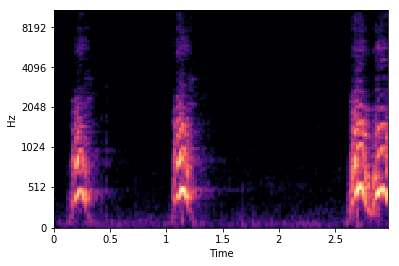

In [6]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(
    librosa.power_to_db(features, ref = np.max),
    x_axis = 'time',
    y_axis = 'mel'
)
plt.show()

We also apply data augmentations to improve the generalization:
* Time Stretching (TS) with four factors: {0.81, 0.93, 1.07, 1.23} (randomly pick one)
* Pitch Shifting (PS) with four factors: {-2, -1, 1, 2} (randomly pick one)

The sample of time stretch:

In [7]:
y, sr = librosa.load('../raw/audio/fold1/101415-3-0-2.wav')
new_wav = librosa.effects.time_stretch(y, 0.81)
librosa.output.write_wav('../temp/time_stretch_sample.wav', new_wav, sr)
ipd.Audio('../temp/time_stretch_sample.wav')

And then the pitch shift:

In [8]:
y, sr = librosa.load('../raw/audio/fold1/101415-3-0-2.wav')
new_wav = librosa.effects.pitch_shift(y, sr, n_steps = 2)
librosa.output.write_wav('../temp/pitch_shift_sample.wav', new_wav, sr)
ipd.Audio('../temp/pitch_shift_sample.wav')

After all progress above, we use h5py package to store the extracted data into hdf5 file.

# 3. Training

As the dataset is already divided into 10 folds, we performed 10-fold cross validation in this part. For simplicity, we only focus on one of the ten folds here.

First import all the package needed here:

In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
import numpy as np
import h5py

Using TensorFlow backend.


Load the extracted data from hdf5 file:

In [3]:
def load_data(path):
    data = []
    aug_data = []
    labels = []
    aug_labels = []
    h5_in = h5py.File(path, 'r')
    for i in range(1, 11):
        key = 'fold' + str(i)
        curr_data = h5_in[key + '_data']
        curr_aug_data = h5_in[key + '_aug_data']
        label = h5_in[key + '_label']
        aug_label = h5_in[key + '_aug_label']
        print(key, 'raw_shape:', curr_data.shape, label.shape,
            'aug_shape:', curr_aug_data.shape, aug_label.shape)
        data.append(curr_data)
        aug_data.append(curr_aug_data)
        labels.append(label)
        aug_labels.append(aug_label)
    return data, aug_data, labels, aug_labels

data, aug_data, labels, aug_labels = load_data('../data/extracted_spectrogram_data.hdf5')

fold1 raw_shape: (873, 128, 128) (873,) aug_shape: (853, 128, 128) (853,)
fold2 raw_shape: (888, 128, 128) (888,) aug_shape: (872, 128, 128) (872,)
fold3 raw_shape: (925, 128, 128) (925,) aug_shape: (892, 128, 128) (892,)
fold4 raw_shape: (990, 128, 128) (990,) aug_shape: (1007, 128, 128) (1007,)
fold5 raw_shape: (936, 128, 128) (936,) aug_shape: (963, 128, 128) (963,)
fold6 raw_shape: (823, 128, 128) (823,) aug_shape: (819, 128, 128) (819,)
fold7 raw_shape: (838, 128, 128) (838,) aug_shape: (882, 128, 128) (882,)
fold8 raw_shape: (806, 128, 128) (806,) aug_shape: (805, 128, 128) (805,)
fold9 raw_shape: (816, 128, 128) (816,) aug_shape: (837, 128, 128) (837,)
fold10 raw_shape: (837, 128, 128) (837,) aug_shape: (790, 128, 128) (790,)


Split the data, generating train and test set: (we perform the 10th round of the cross validation here)

In [4]:
def split_train_test(data, aug_data, labels, aug_labels, test_id):
    train = []
    val = []
    for i in range(10):
        if i == test_id:
            for j in range(labels[i].shape[0]):
                val.append((data[i][j], labels[i][j]))
        else:
            for j in range(labels[i].shape[0]):
                train.append((data[i][j], labels[i][j]))
            for j in range(aug_labels[i].shape[0]):
                train.append((aug_data[i][j], aug_labels[i][j]))
    return train, val

train, val = split_train_test(data, aug_data, labels, aug_labels, 9)

The definition of CNN model:

In [5]:
def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(24, (5, 5), strides = (1, 1), input_shape = input_shape))
    model.add(MaxPooling2D((4, 2), strides = (4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5, 5), padding = 'valid'))
    model.add(MaxPooling2D((4, 2), strides = (4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5, 5), padding = 'valid'))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(rate = 0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate = 0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(
        optimizer = 'Adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

Model setup:

In [6]:
EPOCH = 12

X_train, Y_train = zip(*train)
X_val, Y_val = zip(*val)

input_shape = (X_train[0].shape[0], X_train[0].shape[1], 1)

X_train = np.array([x.reshape(input_shape) for x in X_train])
X_val = np.array([x.reshape(input_shape) for x in X_val])

Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_val = np.array(keras.utils.to_categorical(Y_val, 10))

# set up model
model = create_model(input_shape)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 62, 24)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
activation_2 (Activat

Finally, the main body of training:

In [9]:
model.fit(
    x = X_train,
    y = Y_train,
    epochs = EPOCH,
    batch_size = 128,
    validation_data = (X_val, Y_val)
)

score = model.evaluate(
    x = X_val,
    y = Y_val
)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 15825 samples, validate on 837 samples
Epoch 1/12
15825/15825 [==============================] - 14s 881us/step - loss: 2.1499 - acc: 0.1690 - val_loss: 1.9258 - val_acc: 0.2700
Epoch 2/12
15825/15825 [==============================] - 8s 513us/step - loss: 1.8208 - acc: 0.3248 - val_loss: 1.7280 - val_acc: 0.3345
Epoch 3/12
15825/15825 [==============================] - 8s 514us/step - loss: 1.5458 - acc: 0.4346 - val_loss: 1.5840 - val_acc: 0.3955
Epoch 4/12
15825/15825 [==============================] - 8s 517us/step - loss: 1.3545 - acc: 0.5146 - val_loss: 1.3624 - val_acc: 0.5245
Epoch 5/12
15825/15825 [==============================] - 8s 516us/step - loss: 1.1943 - acc: 0.5790 - val_loss: 1.3118 - val_acc: 0.5293
Epoch 6/12
15825/15825 [==

# 4. Prediction and Statistics

## 4.1 Training result

We save the training log by using redirection and tee command.
    
    E.g. python train.py 2>&1 | tee train.log

In addition, the models were also saved as hdf5 file. In this case, we can draw curves and performing predictions using log files and saved models.

Use log file to draw curves：

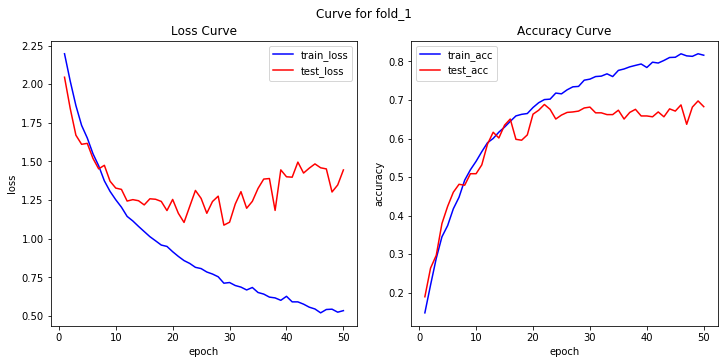

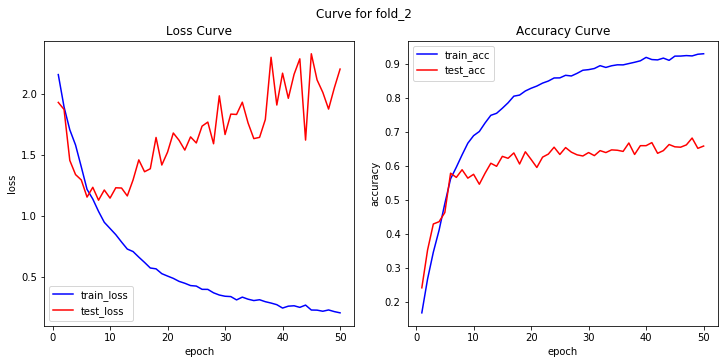

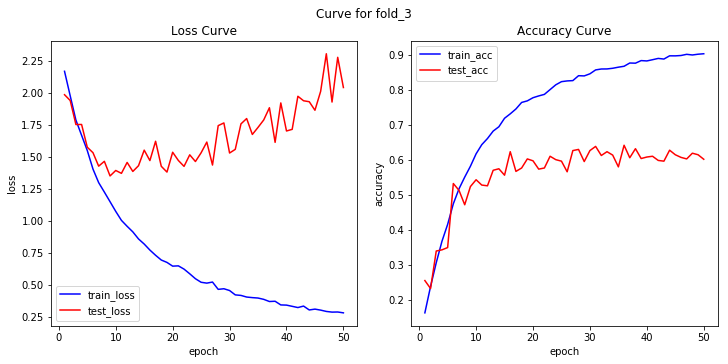

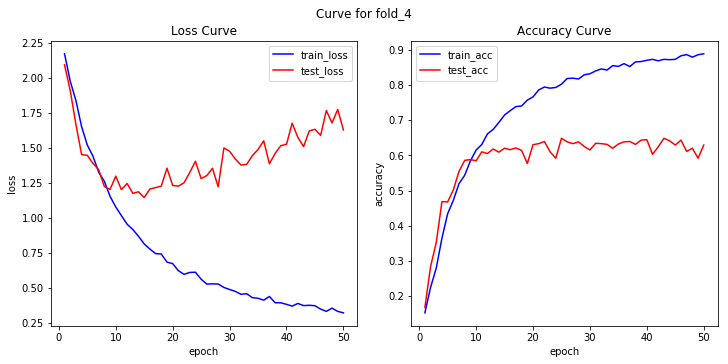

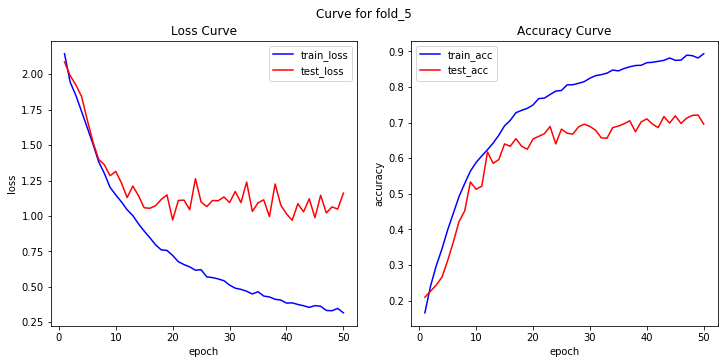

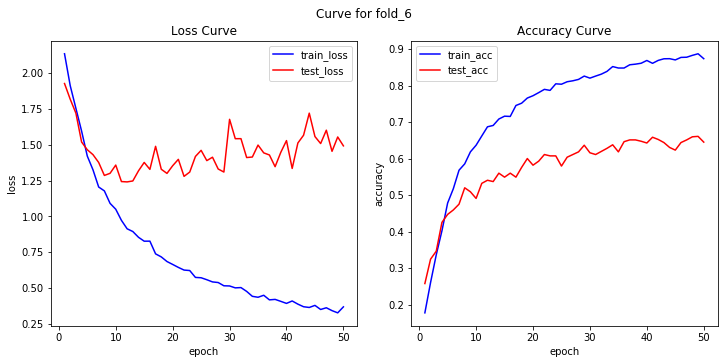

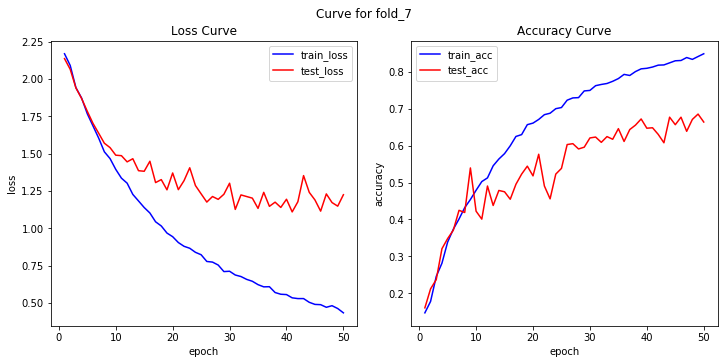

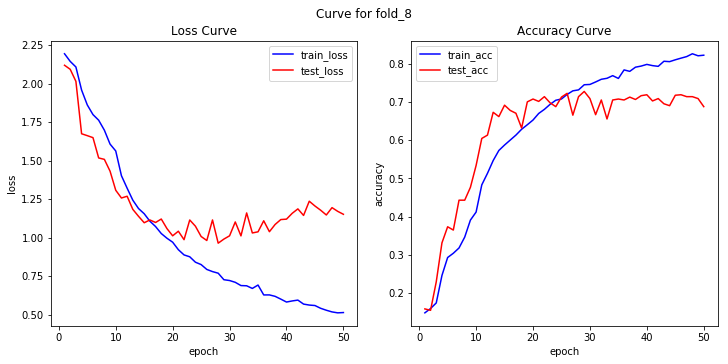

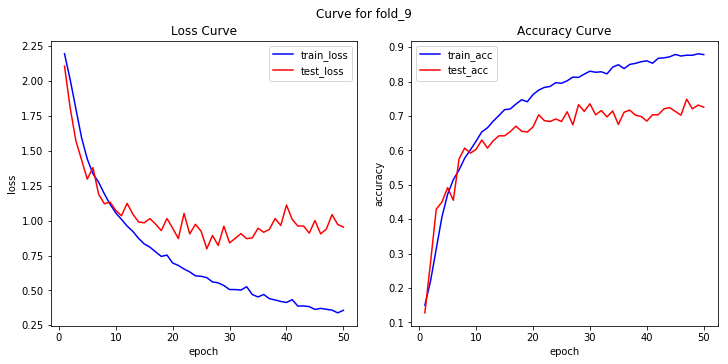

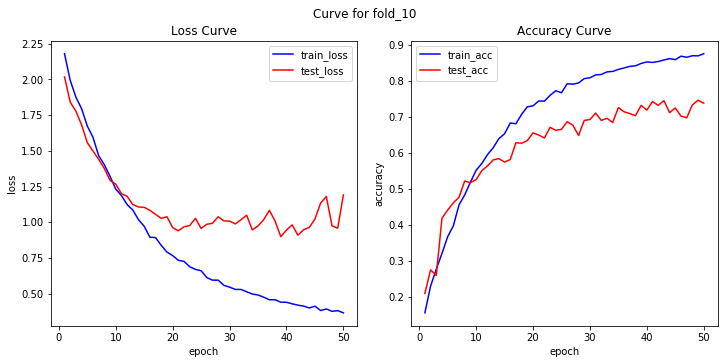

Average loss: 1.449380
Average accuracy: 0.672840


In [9]:
import matplotlib.pyplot as plt

SOURCE = '../log/CNN_Classifier_Layer_3_Epoch_50.log'

def extract_values(path):
    log_file = open(path, 'r')
    train = {}
    test = {}

    curr_train_loss = []
    curr_train_acc = []
    curr_test_loss = []
    curr_test_acc = []
    for line in log_file:
        items = line.strip().split()
        if len(items) == 17 and items[-2] == 'val_acc:':
            curr_train_loss.append(float(items[7]))
            curr_train_acc.append(float(items[10]))
            curr_test_loss.append(float(items[13]))
            curr_test_acc.append(float(items[16]))
        elif len(items) == 4 and items[0] == 'Cross':
            key = 'fold_' + items[-1]
            train[key + '_loss'] = curr_train_loss
            train[key + '_acc'] = curr_train_acc
            test[key + '_loss'] = curr_test_loss
            test[key + '_acc'] = curr_test_acc
            curr_train_loss = []
            curr_train_acc = []
            curr_test_loss = []
            curr_test_acc = []

    log_file.close()
    return train, test

def draw(train, test, fold):
    key = 'fold_' + str(fold)
    train_loss = train[key + '_loss']
    train_acc = train[key + '_acc']
    test_loss = test[key + '_loss']
    test_acc = test[key + '_acc']
    epoch = [elem for elem in range(1, len(train_loss) + 1)]

    fig, axs = plt.subplots(1, 2, figsize = (10, 5), constrained_layout = True)
    fig.suptitle('Curve for ' + key)

    axs[0].plot(epoch, train_loss, c = 'blue', label = 'train_loss')
    axs[0].plot(epoch, test_loss, c = 'red', label = 'test_loss')
    axs[0].set_title('Loss Curve')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    axs[1].plot(epoch, train_acc, c = 'blue', label = 'train_acc')
    axs[1].plot(epoch, test_acc, c = 'red', label = 'test_acc')
    axs[1].set_title('Accuracy Curve')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.show()

def main():
    train, test = extract_values(SOURCE)
    for i in range(10):
        draw(train, test, i + 1)

    loss = 0.0
    accuracy = 0.0
    for i in range(10):
        key = 'fold_' + str(i + 1)
        loss += test[key + '_loss'][-1]
        accuracy += test[key + '_acc'][-1]
    print('Average loss: %f' % (loss / 10))
    print('Average accuracy: %f' % (accuracy / 10))

if __name__ == '__main__':
    main()

## 4.2 Comparison with MFCC + FNN

In [10]:
total = pd.read_csv('../log/compare.csv', sep=',', index_col= ['Epoch'])
total.head()

FNN2    FNN3    FNN4    CNN2    CNN3    CNN4
Epoch                                                
30     46.66%  46.70%  40.99%  66.28%  65.56%  57.15%
50     46.97%  43.53%  43.11%  63.99%  67.28%  65.96%

## 4.3 Analysis

The accuracy for every classes:

In [11]:
recall = pd.read_csv('../log/recall.csv', sep=',', index_col= ['fold'])
print('Statistics for CNN3 after 50 epoch:')
recall.head(11)

Statistics for CNN3 after 50 epoch:


total_acc  air_conditioner  car_horn  children_playing  dog_bark  \
fold                                                                        
1         0.682703            0.640  0.972222             0.800     0.900   
2         0.658784            0.310  0.547619             0.910     0.940   
3         0.602162            0.230  0.976744             0.730     0.820   
4         0.629293            0.420  0.610169             0.560     0.820   
5         0.695513            0.330  0.724490             0.810     0.780   
6         0.645200            0.310  1.000000             0.850     0.920   
7         0.663484            0.750  0.678571             0.770     0.880   
8         0.687345            0.330  0.833333             0.730     0.840   
9         0.725490            0.230  0.906250             0.850     0.800   
10        0.738351            0.600  0.939394             0.840     0.730   
average   0.672833            0.415  0.818879             0.785     0.843   

         drilling  engine_idling  gun_shot  jackhammer     siren  street_music  
fold                                                                            
1           0.620       0.447917  0.857143    0.408333  0.813953         0.730  
2           0.710       0.620000  0.857143    0.183333  0.824176         0.860  
3           0.620       0.317757  1.000000    0.300000  0.848739         0.680  
4           0.710       0.532710  0.763158    0.375000  0.777108         0.760  
5           0.480       0.420561  0.950000    0.950000  0.915493         0.780  
6           0.750       0.345794  0.956522    0.352941  0.783784         0.570  
7           0.650       0.481132  0.803922    0.381579  0.558442         0.680  
8           0.810       0.568182  0.666667    0.564103  0.900000         0.720  
9           0.600       0.696629  0.870968    0.926829  0.975610         0.700  
10          0.740       0.548387  0.937500    0.937500  0.530120         0.810  
average     0.669       0.497907  0.866302    0.537962  0.792743         0.729

The confusion matrix of fold 2:

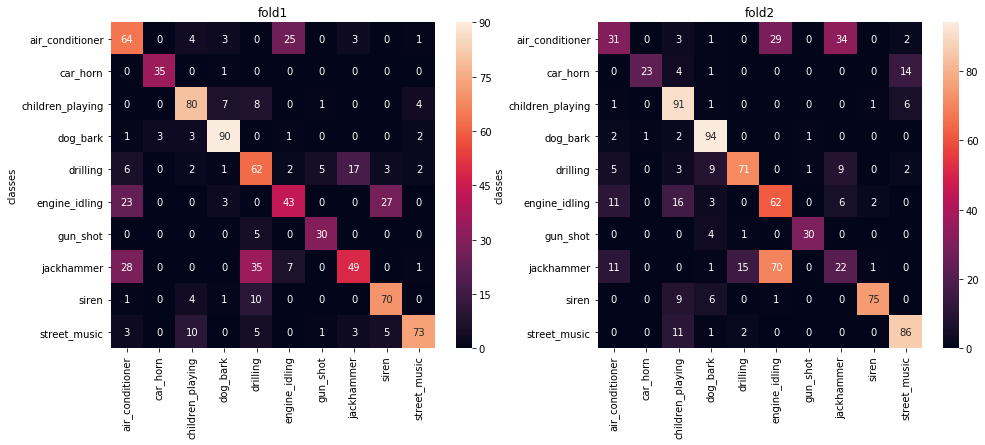

In [12]:
import seaborn as sns

def confusion_matrix():
    example1 = pd.read_csv('../log/fold_1.csv', sep=',', index_col= ['classes'])
    example2 = pd.read_csv('../log/fold_2.csv', sep=',', index_col= ['classes'])
    plt.figure(figsize = (16, 6))
    plt.subplot(1, 2, 1)
    plt.title('fold1')
    sns.heatmap(example1, annot=True)
    plt.subplot(1, 2, 2)
    plt.title('fold2')
    sns.heatmap(example2, annot=True)
    plt.show()

confusion_matrix()

The Mel-spectrogram patterns:

Shape of the feature: (128, 128)
Shape of the feature: (128, 113)
Shape of the feature: (128, 128)
Shape of the feature: (128, 128)


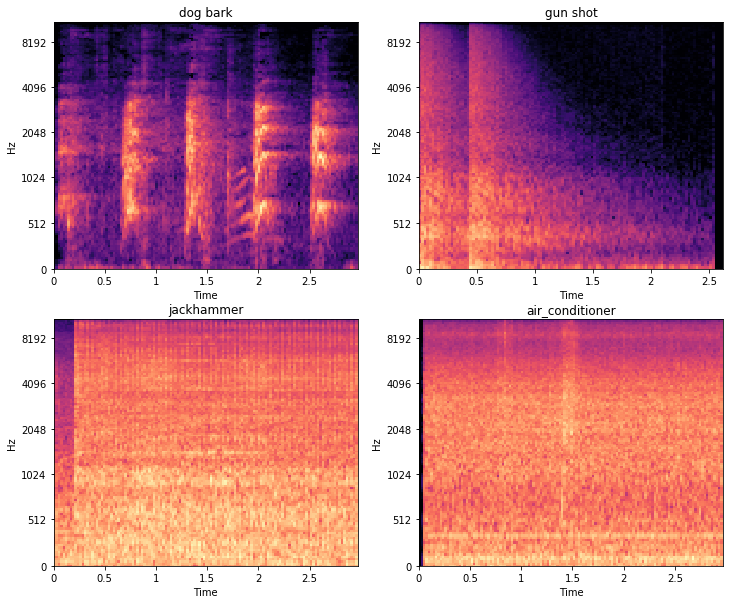

In [13]:
def show_pattern():
    dog_bark = get_features('../raw/audio/fold2/100652-3-0-0.wav')
    gun_shot = get_features('../raw/audio/fold1/102305-6-0-0.wav')
    jackhammer = get_features('../raw/audio/fold1/103074-7-0-0.wav')
    air_conditioner = get_features('../raw/audio/fold5/100852-0-0-0.wav')

    plt.figure(figsize = (12, 10))
    plt.subplot(2, 2, 1)
    plt.title('dog bark')
    librosa.display.specshow(
        librosa.power_to_db(dog_bark, ref = np.max),
        x_axis = 'time',
        y_axis = 'mel'
    )
    plt.subplot(2, 2, 2)
    plt.title('gun shot')
    librosa.display.specshow(
        librosa.power_to_db(gun_shot, ref = np.max),
        x_axis = 'time',
        y_axis = 'mel'
    )
    plt.subplot(2, 2, 3)
    plt.title('jackhammer')
    librosa.display.specshow(
        librosa.power_to_db(jackhammer, ref = np.max),
        x_axis = 'time',
        y_axis = 'mel'
    )
    plt.subplot(2, 2, 4)
    plt.title('air_conditioner')
    librosa.display.specshow(
        librosa.power_to_db(air_conditioner, ref = np.max),
        x_axis = 'time',
        y_axis = 'mel'
    )
    plt.show()

show_pattern()

## 4.4 Prediction

In [14]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import load_model
import librosa
import numpy as np

Using TensorFlow backend.


In [15]:
# dog_bark
dog_bark = '../raw/audio/fold1/101415-3-0-2.wav'
# gun_shot
gun_shot = '../raw/audio/fold1/102305-6-0-0.wav'
# jackhammer
jackhammer = '../raw/audio/fold1/103074-7-1-0.wav'

In [24]:
model_path = '../models/CNN_Classifier_Layer_3_Epoch_50_Fold_1.h5'
mapping = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

def load_audio(path):
    y1, sr1 = librosa.load(path, duration = 2.97)
    ps = librosa.feature.melspectrogram(y = y1, sr = sr1)

    padding = 0
    if ps.shape != (128, 128):
        padding = 1
        diff = 128 - ps.shape[1]
        pattern = [0.0] * 128
        paddings = []
        for i in range(diff):
            paddings.append(pattern)
        paddings = np.array(paddings)
        ps = np.concatenate((ps, paddings.T), axis = 1)

    return ps

def predict(audio):
    source = audio

    gt = int(source.split('-')[1])
    data = load_audio(source)
    model = load_model(model_path)
    data = data.reshape((1, 128, 128, 1))
    predict_vec = model.predict(data)

    label = ''
    max_prob = -1
    for i in range(predict_vec.shape[1]):
        if predict_vec[0, i] > max_prob:
            label = mapping[i]
            max_prob = predict_vec[0, i]

    print('The label is:', mapping[gt])
    print('The prediction is:', label)

In [17]:
ipd.Audio(dog_bark)

In [25]:
predict(dog_bark)

The label is: dog_bark
The prediction is: dog_bark


In [20]:
ipd.Audio(gun_shot)

In [21]:
predict(gun_shot)

The label is: gun_shot
The prediction is: gun_shot


In [22]:
ipd.Audio(jackhammer)

In [23]:
predict(jackhammer)

The label is: jackhammer
The prediction is: jackhammer
